## Import dependencies

In [1]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# stats
#import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from neuropop import NeuroPop
from neurovis import NeuroVis

# local
import V4pyutils

## Read in files

### List files

In [2]:
h5path = '../V4pydata/H5data/M3/'
fname = glob.glob(h5path+'/*89a*')
fname
glob.glob(h5path+'/*89a*')

['../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5_imagefeatures_wip',
 '../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev_imagefeatures_wip.h5']

### Artificial

In [3]:
# Read using deepdish
art_file = fname[1]
print art_file
art_dat = dd.io.load(art_file)

../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5


### Natural

In [4]:
# Read using deepdish
nat_file = fname[2]
print nat_file
nat_dat = dd.io.load(nat_file)

../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


### Sanity check: compare firing rates for artificial vs. natural

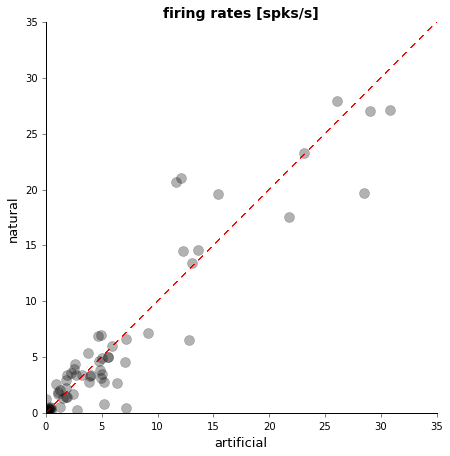

In [5]:
# Artificial
art_rates = dict()
for neuron_id in art_dat['spikes']:
    art_rates[neuron_id]=V4pyutils.get_firing_rate(art_dat['spikes'][neuron_id])

# Natural
nat_rates = dict()
for neuron_id in nat_dat['spikes']:
    nat_rates[neuron_id]=V4pyutils.get_firing_rate(nat_dat['spikes'][neuron_id])

# Plot artificial vs. natural firing rates
plt.figure(figsize=(7,7))
for i in art_rates:
    plt.plot([0,35],[0,35],'--r', lw=0.1)
    plt.plot(art_rates[i], nat_rates[i],'ko', alpha=0.3, ms=10)
    plt.xlabel('artificial')
    plt.ylabel('natural')
    plt.title('firing rates [spks/s]')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.axis('equal')
plt.show()

## Get features (X)

In [6]:
params = dict()
params['n_bins'] = 16 #number of bins of the histogram
params['window'] = [50, 300] #
params['radius'] = 200
params['n_patches'] = 16 #for natural stimuli
params['n_blocks'] = np.int(np.sqrt(params['n_patches']))
params['stimpath'] = '../V4pydata'

### artificial features

In [7]:
# Collect features of interest into a dict
features_art = dict()
features_art['col'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['row'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['hue'] = np.array([art_dat['features'][i]['hue'] for i in art_dat['features']])
features_art['onset_times'] = np.array([art_dat['events'][i]['onset'] for i in art_dat['events']])
features_art['offset_times'] = np.array([art_dat['events'][i]['offset'] for i in art_dat['events']])

# DataFrame
features_art_df = pd.DataFrame.from_dict(features_art, orient='columns', dtype=None)

# add some more features
features_art_df['off_to_onset_times'] = features_art['onset_times']-np.roll(features_art['offset_times'],1)
features_art_df['off_to_onset_times'][0] = -999.0

features_art_df['hue_prev'] = np.roll(features_art['hue'], 1)
features_art_df['hue_prev'][0] = -999.0

features_art_df['stim_dur'] = features_art_df['offset_times']-features_art_df['onset_times']

# sort columns

cols = features_art_df.columns.tolist()

new_order = ['onset_times', 'offset_times', 'col', 'row', 
             'hue', 'hue_prev', 'stim_dur', 'off_to_onset_times']

features_art_df = features_art_df[new_order]

features_art_df.head()

,onset_times,offset_times,col,row,hue,hue_prev,stim_dur,off_to_onset_times
0,66.106033,66.308333,368.0,368.0,1.822645,-999.000000,0.202300,-999.000000
1,66.435933,66.633233,366.0,366.0,-0.131535,1.822645,0.197300,0.127600
2,66.746033,66.947067,367.0,367.0,1.609290,-0.131535,0.201033,0.112800
3,67.070933,67.272667,376.0,376.0,1.250616,1.609290,0.201733,0.123867
4,69.508967,69.726167,366.0,366.0,3.125854,1.250616,0.217200,2.236300


In [8]:
# Encode hue histogram as one-hot vector (sort of)
Xart = V4pyutils.onehothue(features_art_df['hue'], n_bins=params['n_bins'])

### natural features

#### non-visual

In [9]:
for_features_nat = nat_dat['eyes'][0].keys()
for i in ['imname','impath']: for_features_nat.remove(i) 

features_nat = dict()
for feat in for_features_nat:
    features_nat[feat] = np.array([nat_dat['eyes'][fix][feat] for fix in nat_dat['eyes']]) 

In [10]:
features_nat_df = pd.DataFrame(features_nat)
features_nat_df['badfix'] = features_nat_df['badfix']==0
features_nat_df['in_sac_blink'] = features_nat_df['in_sac_blink']==1
features_nat_df['out_sac_blink'] = features_nat_df['out_sac_blink']==1

features_nat_df['fix_duration'] = features_nat_df['fix_offset'] - features_nat_df['fix_onset']
features_nat_df['next_fix_duration'] = np.append(features_nat_df['fix_duration'][1:], 0)
features_nat_df['prev_fix_duration'] = np.append(0, features_nat_df['fix_duration'][0:-1])
features_nat_df['in_screen'] = np.all((features_nat_df['col']>=1, features_nat_df['col']<=1024, \
                                features_nat_df['row']>=1, features_nat_df['row']<=768), axis=0)
features_nat_df['row_drift'] = features_nat_df['fix_offset_row']-features_nat_df['fix_onset_row']
features_nat_df['col_drift'] = features_nat_df['fix_offset_col']-features_nat_df['fix_onset_col']
features_nat_df['drift'] = np.abs(features_nat_df['row_drift'])+np.abs(features_nat_df['col_drift'])

# sort columns
cols = features_nat_df.columns.tolist()
cols = ['trial', 'fixation', 'fix_onset', 'fix_offset', 'row', 'col',
        'fix_onset_row', 'fix_onset_col', 'fix_offset_row', 'fix_offset_col',
        'in_sac_blink', 'in_sac_dur', 'in_sac_pkvel',
        'out_sac_blink', 'out_sac_dur', 'out_sac_pkvel',
        'fix_duration','prev_fix_duration', 'next_fix_duration',
        'row_drift', 'col_drift', 'drift',
        'in_screen', 'badfix']

features_nat_df = features_nat_df[cols]

features_nat_df.head()

,trial,fixation,fix_onset,fix_offset,row,col,fix_onset_row,fix_onset_col,fix_offset_row,fix_offset_col,...,out_sac_dur,out_sac_pkvel,fix_duration,prev_fix_duration,next_fix_duration,row_drift,col_drift,drift,in_screen,badfix
0,1,1,2.230,2.557,425.0,578.0,434.0,565.0,414.0,586.0,...,0.039,12.311564,0.327,0.000,0.183,-20.0,21.0,41.0,True,False
1,1,2,2.596,2.779,499.0,597.0,489.0,594.0,496.0,595.0,...,0.053,141.512974,0.183,0.327,0.113,7.0,1.0,8.0,True,True
2,1,3,2.832,2.945,678.0,310.0,676.0,311.0,677.0,311.0,...,0.051,126.929517,0.113,0.183,0.830,1.0,0.0,1.0,True,True
3,1,4,2.996,3.826,460.0,82.0,469.0,108.0,461.0,65.0,...,0.057,129.210255,0.830,0.113,0.173,-8.0,-43.0,51.0,True,False
4,1,5,3.883,4.056,174.0,234.0,180.0,226.0,172.0,237.0,...,0.055,224.264790,0.173,0.830,0.193,-8.0,11.0,19.0,True,True


#### visual

In [11]:
# Extract a patch of arbitrary radius around a fixation and compute hue histograms

load_X = True
save_X = False

if load_X:
    fixation_list = dd.io.load('fixation_list.h5')
    Xnat = dd.io.load('Xnat.h5')
    hue_nat_mean = dd.io.load('hue_nat_mean.h5')
    hue_nat_kurt = dd.io.load('hue_nat_kurt.h5')
    Xnat_shuf = dd.io.load('Xnat_shuf.h5')

else:
    stimpath = params['stimpath']
    R = params['radius']
    n_patches = params['n_patches']
    n_blocks = params['n_blocks']

    # List of included fixations
    fixation_list = list()

    # Dictionaries for real and shuffled control features
    Xnat = dict()
    hue_nat_mean = dict()
    hue_nat_kurt = dict()
    Xnat_shuf = dict()

    #Grid patches
    for grd in np.arange(n_patches): 
        Xnat[grd] = []
        hue_nat_mean[grd] = []
        hue_nat_kurt[grd] = []
        Xnat_shuf[grd] = []

    for fx in range(len(nat_dat['eyes'])):
        if fx%1000==0:
            print fx

        # Read in the image and shuffle image
        if (fx > 0 and nat_dat['eyes'][fx]['imname'] != nat_dat['eyes'][fx-1]['imname']) or fx == 0:
            I = V4pyutils.get_image(nat_dat['eyes'][fx], stimpath)
            fx_rnd = np.random.randint(low=0, high=len(nat_dat['eyes']), size=1)[0]
            Ishuf = V4pyutils.get_image(nat_dat['eyes'][fx_rnd], stimpath)

        # Get gaze location
        r = nat_dat['eyes'][fx]['row']
        c = nat_dat['eyes'][fx]['col']

        #If gaze is within the image borders
        if (nat_dat['eyes'][fx]['row'] > R) and \
            (nat_dat['eyes'][fx]['row'] < (768 - R)) and \
            (nat_dat['eyes'][fx]['col'] > R) and \
            (nat_dat['eyes'][fx]['col'] < (1024 - R)) \
            and (not np.isnan(r)) and (not np.isnan(c)):

            r = int(r)
            c = int(c)

            # Extract patches
            G = I[r-R:r+R, c-R:c+R, :]
            Gshuf = Ishuf[r-R:r+R, c-R:c+R, :]

            # Divide it into grids    
            G_block = V4pyutils.grid_image(G, [n_blocks, n_blocks])
            for grd in range(0, n_patches):
                hue = V4pyutils.get_hue_image(G_block[grd,:,:,:])
                Xnat[grd].append(V4pyutils.bin_it(np.ravel(hue), params))
                hue_nat_mean[grd].append(stats.circmean(np.ravel(hue)))
                hue_nat_kurt[grd].append(V4pyutils.circkurtosis(np.ravel(hue)))


            Gshuf_block = V4pyutils.grid_image(Gshuf, [n_blocks, n_blocks])
            for grd in range(0, n_patches):
                hue = V4pyutils.get_hue_image(Gshuf_block[grd,:,:,:])
                Xnat_shuf[grd].append(V4pyutils.bin_it(hue, params))

            fixation_list.append(fx)

        #else:
            #print r,c
            #print 'outside'

    for grd in range(0, 16):
        Xnat[grd] = np.array(Xnat[grd])
        Xnat_shuf[grd] = np.array(Xnat_shuf[grd])
    
    if save_X:
        dd.io.save('Xnat.h5', Xnat)
        dd.io.save('hue_nat_mean.h5', hue_nat_mean)
        dd.io.save('hue_nat_kurt.h5', hue_nat_kurt)
        dd.io.save('Xnat_shuf.h5', Xnat_shuf)
        dd.io.save('fixation_list.h5', fixation_list)

## Explore data by visualizing PSTHs

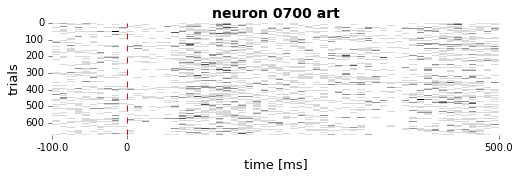

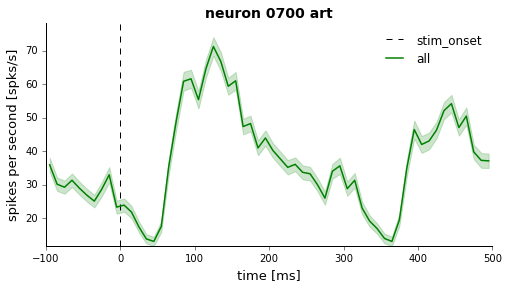

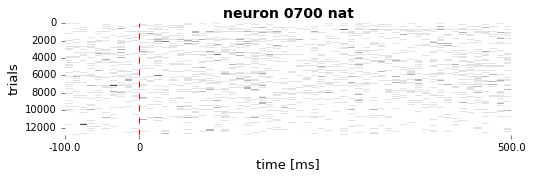

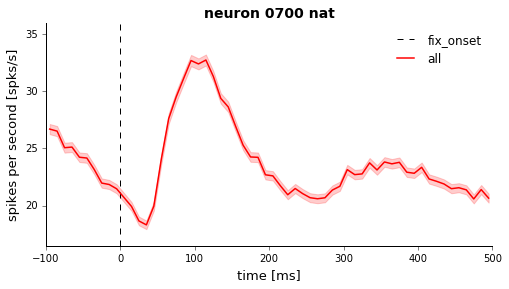

In [49]:
params['selected_neuron'] = '0700'

neuron_id = params['selected_neuron']
art_neuron = NeuroVis(art_dat['spikes'][neuron_id], name='%s art' % neuron_id)
nat_neuron = NeuroVis(nat_dat['spikes'][neuron_id], name='%s nat' % neuron_id)

art_events = dict()
art_events['stim_onset'] = np.array([art_dat['eyes'][i]['stim_onset'] for i in art_dat['eyes']])

psth = art_neuron.get_raster(events=art_events['stim_onset']);
psth = art_neuron.get_psth(events=art_events['stim_onset'], plot=False);
art_neuron.plot_psth(psth=psth, event_name='stim_onset', colors='g');

nat_events = dict()
nat_events['fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in nat_dat['eyes']])

psth = nat_neuron.get_raster(events=nat_events['fix_onset']);
psth = nat_neuron.get_psth(events=nat_events['fix_onset'], plot=False);
nat_neuron.plot_psth(psth=psth, event_name='fix_onset', colors='r');

## Get spike counts (Y)

### artificial

In [16]:
# Get number of samples and neurons
n_samples = len(art_dat['events'])
n_neurons = len(art_dat['spikes'].keys())

# Initialize spikecounts vector
Yart = dict()
for neuron_id in art_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = art_dat['spikes'][neuron_id]
    
    # Extract spikecounts
    if len(spiketimes) > 1:
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Yart[neuron_id] = neuron.get_spikecounts(features_art['onset_times'], window=params['window'])
    else:
        Yart[neuron_id] = np.zeros(n_samples)

### natural

In [17]:
features_nat = dict()
features_nat['valid_fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in fixation_list])

In [18]:
# Initialize spikecounts vector
Ynat = dict()

# Only collect spikecounts for included fixations
n_samples = len(fixation_list)

#for neuron_id in nat_dat['spikes'].keys():
neuron_id = params['selected_neuron']
# Extract spiketimes for a given neuron
spiketimes = nat_dat['spikes'][neuron_id]

if len(spiketimes) > 1:
    # Extract spikecounts
    neuron = NeuroVis(spiketimes, name=neuron_id)
    Ynat[neuron_id] = neuron.get_spikecounts(features_nat['valid_fix_onset'], window=params['window'])
else:
    Ynat[neuron_id] = np.zeros(n_samples)

### sanity check: print shapes of data

In [19]:
selected_neuron = params['selected_neuron']
print "Xart (%d, %d); Yart (%d,)" % (np.shape(Xart)[0], np.shape(Xart)[1], np.shape(Yart[selected_neuron])[0])
print "Xnat (%d, %d); Ynat (%d,)" % (np.shape(Xnat[0])[0], np.shape(Xnat[0])[1], np.shape(Ynat[selected_neuron])[0])

Xart (673, 16); Yart (673,)
Xnat (7575, 16); Ynat (7575,)


## Model fitting

In [20]:
selected_neuron = params['selected_neuron']

### fit art

In [21]:
Yt_art_hat, PR2_art = V4pyutils.fit_cv(Xart, Yart[selected_neuron], algorithm = 'XGB_poisson', verbose = 1)

pR2_cv: 0.380907 (+/- 0.018531)


In [22]:
Models_art = dict()
Models_art['hue'] = dict()
Models_art['hue']['covariates'] = ['hue']

Models_art['Joint'] = dict()
Models_art['Joint']['covariates'] = ['hue', 'off_to_onset_times', 'onset_times']


for i, model in enumerate(Models_art):
    print 'running model %d of %d: %s' % (i+1, len(Models_art), model)
    X = features_art_df[Models_art[model]['covariates']].values
    Yt_hat, PR2 = V4pyutils.fit_cv(X, Yart[selected_neuron], 
                                       algorithm='XGB_poisson', 
                                       verbose=1)
    
    Models_art[model]['Yt_hat'], Models_art[model]['PR2'] = Yt_hat, PR2    
    print ''

running model 1 of 2: hue
pR2_cv: 0.423378 (+/- 0.017590)

running model 2 of 2: Joint
pR2_cv: 0.439096 (+/- 0.019927)



### fit nat

In [23]:
Yt_nat_hat = dict()
PR2_nat = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat[patch_n], PR2_nat[patch_n] = V4pyutils.fit_cv(Xnat[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             label=[features_nat_df['trial'][fixation_list]],
                                                             verbose = 0)
    
    print 'patch %d: pseudo-R2: %.4f +/- %.4f' % (patch_n, np.mean(PR2_nat[patch_n]), 
                                                 np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n])))

patch 0: pseudo-R2: 0.0047 +/- 0.0026
patch 1: pseudo-R2: 0.0061 +/- 0.0027
patch 2: pseudo-R2: 0.0063 +/- 0.0037
patch 3: pseudo-R2: 0.0049 +/- 0.0039
patch 4: pseudo-R2: 0.0116 +/- 0.0029
patch 5: pseudo-R2: 0.0128 +/- 0.0042
patch 6: pseudo-R2: 0.0091 +/- 0.0053
patch 7: pseudo-R2: 0.0052 +/- 0.0031
patch 8: pseudo-R2: 0.0095 +/- 0.0032
patch 9: pseudo-R2: 0.0222 +/- 0.0051
patch 10: pseudo-R2: 0.0339 +/- 0.0054
patch 11: pseudo-R2: 0.0156 +/- 0.0038
patch 12: pseudo-R2: 0.0179 +/- 0.0026
patch 13: pseudo-R2: 0.0395 +/- 0.0025
patch 14: pseudo-R2: 0.0640 +/- 0.0040
patch 15: pseudo-R2: 0.0416 +/- 0.0052


### fit nat shuffled

In [24]:
Yt_nat_hat_shuf = dict()
PR2_nat_shuf = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat_shuf[patch_n], PR2_nat_shuf[patch_n] = V4pyutils.fit_cv(Xnat_shuf[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             label=[features_nat_df['trial'][fixation_list]],
                                                             verbose = 0)
    
    print 'patch %d: pseudo-R2: %.3f +/- %.3f' % (patch_n, np.mean(PR2_nat_shuf[patch_n]), 
                                                 np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf)))

patch 0: pseudo-R2: -0.005 +/- 0.007
patch 1: pseudo-R2: -0.009 +/- 0.006
patch 2: pseudo-R2: -0.004 +/- 0.006
patch 3: pseudo-R2: -0.009 +/- 0.006
patch 4: pseudo-R2: -0.005 +/- 0.007
patch 5: pseudo-R2: -0.002 +/- 0.007
patch 6: pseudo-R2: -0.007 +/- 0.007
patch 7: pseudo-R2: -0.007 +/- 0.005
patch 8: pseudo-R2: -0.002 +/- 0.005
patch 9: pseudo-R2: -0.005 +/- 0.006
patch 10: pseudo-R2: -0.005 +/- 0.007
patch 11: pseudo-R2: -0.007 +/- 0.007
patch 12: pseudo-R2: -0.007 +/- 0.007
patch 13: pseudo-R2: -0.006 +/- 0.008
patch 14: pseudo-R2: -0.004 +/- 0.009
patch 15: pseudo-R2: -0.007 +/- 0.009


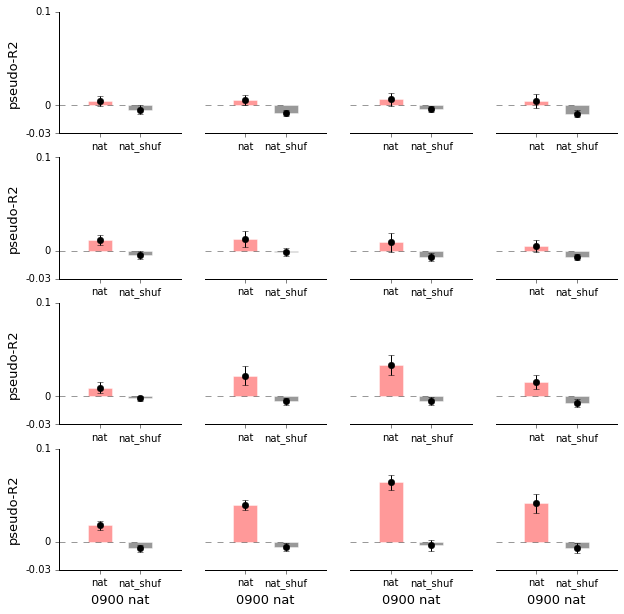

In [25]:
plt.figure(figsize=(10,10))
plt.title('neuron %s' % selected_neuron)
ylim = [-0.03,0.1]
for patch_n in PR2_nat:
    mean_pR2 = np.mean(PR2_nat[patch_n])
    sem_pR2 = np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n]))
    mean_pR2_shuf = np.mean(PR2_nat_shuf[patch_n])
    sem_pR2_shuf = np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf[patch_n]))

    plt.subplot(4,4,patch_n+1)

    plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
            ecolor='k', alpha=0.4, color=['r','k'], ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
            tick_label=['nat','nat_shuf'])
    
    plt.plot([-1,1],[0,0],'--k', alpha=0.4)
    plt.plot([0,1], [mean_pR2, mean_pR2_shuf], '.', c='k', markersize=13)
    plt.xlim([-1,2])
   
    plt.ylim(ylim)
    
    ax = plt.gca()
    
    if patch_n>11:
        plt.xlabel(nat_neuron.name)
    if patch_n%4==0:
        plt.ylabel('pseudo-R2')
        plt.yticks([ylim[0],0,ylim[1]],[ylim[0],'0',ylim[1]])
    if patch_n%4>0:
        ax.spines['left'].set_visible(False)
        plt.yticks(ylim,['',''])
        plt.tick_params(axis='y', left='off')
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')

plt.show()

### Let's include non-image features
#### for best looking patch 14

In [26]:
patch_n = 14

Models_nat = dict()
Models_nat['M1'] = dict()
Models_nat['M1']['covariates'] = ['col','row']
Models_nat['M1_c'] = dict()
Models_nat['M1_c']['covariates'] = Models_nat['M1']['covariates']

Models_nat['M2'] = dict()
Models_nat['M2']['covariates'] = ['col','row','trial']
Models_nat['M2_c'] = dict()
Models_nat['M2_c']['covariates'] = Models_nat['M2']['covariates']

Models_nat['M3'] = dict()
Models_nat['M3_c'] = dict()
Models_nat['M3']['covariates'] = ['col','row','trial','fixation', 
                                  'out_sac_blink', 'in_sac_dur', 'fix_duration', 'prev_fix_duration', 'drift', 
                                  'out_sac_dur', 'next_fix_duration']
#Models_nat['M3']['covariates'] = ['col','row','trial','fixation']
Models_nat['M3_c']['covariates'] = Models_nat['M3']['covariates']


for i, model in enumerate(sorted(Models_nat.keys())):
    print 'running model %d of %d: %s' % (i+1, len(Models_nat), model)
    
    X = features_nat_df[Models_nat[model]['covariates']].values[fixation_list]
    if model[-2:] == '_c':
        X = np.concatenate((X, Xnat[patch_n]), axis=1)
        
    Yt_hat, PR2 = V4pyutils.fit_cv(X, Ynat[selected_neuron], 
                                       algorithm='XGB_poisson',
                                       label=[features_nat_df['trial'][fixation_list]],
                                       verbose=1)
    
    Models_nat[model]['Yt_hat'], Models_nat[model]['PR2'] = Yt_hat, PR2
    
    X = features_nat_df[Models_nat[model]['covariates']].values[fixation_list]
    if model[-2:] == '_c':
        print 'shuffle control:'
        X = np.concatenate((X, Xnat_shuf[patch_n]), axis=1)
        
        Yt_hat, PR2 = V4pyutils.fit_cv(X, Ynat[selected_neuron], 
                                           algorithm='XGB_poisson',
                                           label=[features_nat_df['trial'][fixation_list]],
                                           verbose=1)
        Models_nat[model]['Yt_hat_shuf'], Models_nat[model]['PR2_shuf'] = Yt_hat, PR2
    
    print '' 

running model 1 of 6: M1
pR2_cv: 0.019246 (+/- 0.002233)

running model 2 of 6: M1_c
pR2_cv: 0.076804 (+/- 0.004136)
shuffle control:
pR2_cv: 0.015405 (+/- 0.002753)

running model 3 of 6: M2
pR2_cv: 0.026871 (+/- 0.004541)

running model 4 of 6: M2_c
pR2_cv: 0.085473 (+/- 0.004194)
shuffle control:
pR2_cv: 0.025008 (+/- 0.004659)

running model 5 of 6: M3
pR2_cv: 0.034227 (+/- 0.004990)

running model 6 of 6: M3_c
pR2_cv: 0.088511 (+/- 0.003929)
shuffle control:
pR2_cv: 0.033032 (+/- 0.004499)



In [27]:
Models_nat['hue'] = dict()
Models_nat['hue']['Yt_hat'], Models_nat['hue']['PR2'] = Yt_nat_hat[patch_n], PR2_nat[patch_n]

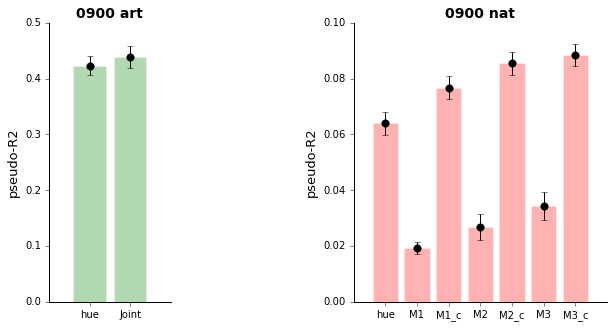

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(141)
models_for_plot = ['hue','Joint']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_art, title=art_neuron.name, color='g')

plt.subplot(122)
models_for_plot = ['hue','M1', 'M1_c', 'M2', 'M2_c', 'M3', 'M3_c']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_nat, title=nat_neuron.name)
plt.show()

## Visualization

### art

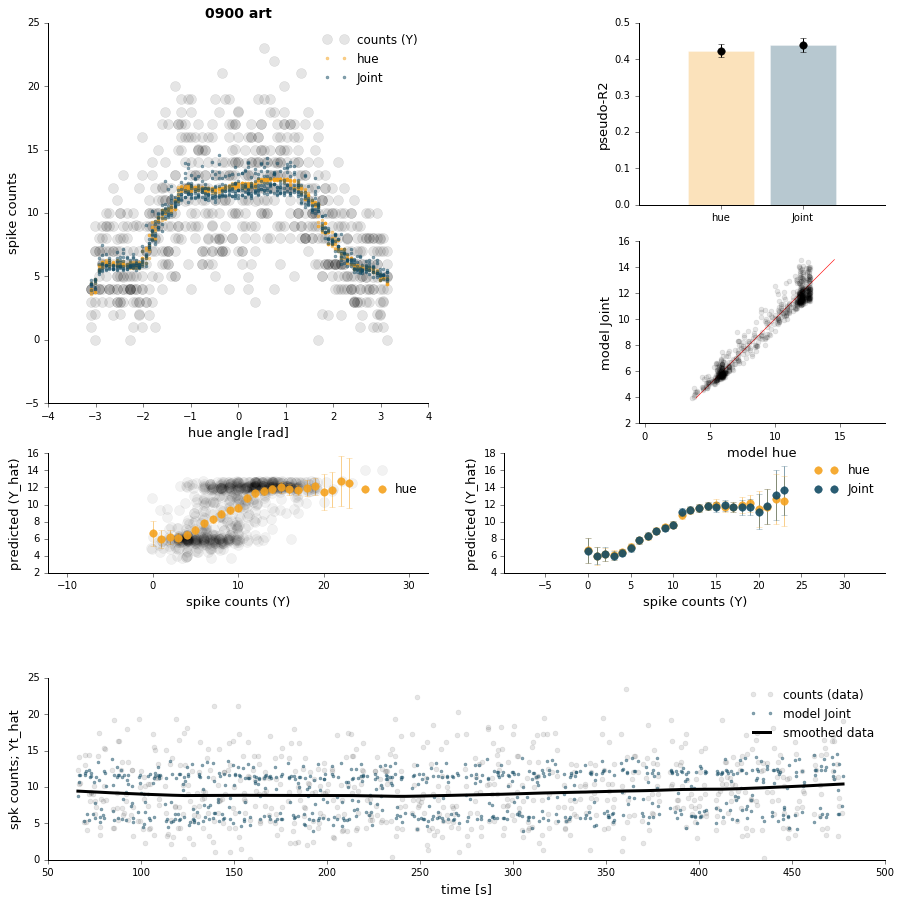

In [32]:
colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E', '#FF07CD']

title=art_neuron.name

models_for_plot = ['hue','Joint']
plt.figure(figsize=(15,15))
plt.subplot(221)
V4pyutils.plot_tuning_curve(models_for_plot, hues=features_art['hue'], models=Models_art, 
                  Y=Yart[selected_neuron], title=art_neuron.name) 
plt.subplot(433)
V4pyutils.plot_model_comparison(models_for_plot, models=Models_art, color=colors)

plt.subplot(627)
models_for_plot = ['hue']
title = '%s artificial' % selected_neuron
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Yart[selected_neuron], models=Models_art)


plt.subplot(628)
models_for_plot = ['hue','Joint']
title = '%s artificial' % selected_neuron
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Yart[selected_neuron], models=Models_art)

plt.subplot(436)
V4pyutils.plot_model_vs_model(models_for_plot=models_for_plot, models=Models_art)

plt.subplot(414)
V4pyutils.plot_model_vs_time(model_for_plot='Joint', Y=Yart[selected_neuron], models=Models_art, 
                       x_variable=features_art_df['onset_times'], 
                       color=colors[1], lowess_frac=0.3)
plt.savefig('sample.pdf')
plt.show()

In [33]:
#artificial
conditions = dict()

cond = 0
conditions[cond]= dict()
conditions[cond]['stim_dur'] = [0.1, 0.2]

psth_art = art_neuron.get_psth(features_art_df['onset_times'], 
                               features_art_df, conditions, 
                               window=[-200,700], binsize=20, plot=False);

#natural
conditions = dict()
cond = 0
conditions[cond]= dict()
conditions[cond]['fix_duration'] = [0.1, 0.2] 

psth_nat = nat_neuron.get_psth(features_nat_df['fix_onset'], 
                               features_nat_df, conditions, window=[-200,700], 
                               binsize=20, plot=False);

psth = psth_nat
psth['conditions'][1] = psth_art['conditions'][0] 
psth['data'][1] = dict()
psth['data'][1]['mean'] = psth_art['data'][0]['mean']
psth['data'][1]['sem'] = psth_art['data'][0]['sem']

In [34]:
print 'Art models --------------------'
m_art = ['hue', 'Joint']

for m in m_art:
    print 'model %s: %s' % (m, str(Models_art[m]['covariates']))

print
print 'Nat models --------------------'
m_nat = ['M1', 'M2', 'M3']

for m in m_nat:
    print 'model %s: %s' % (m, str(Models_nat[m]['covariates']))

Art models --------------------
model hue: ['hue']
model Joint: ['hue', 'off_to_onset_times', 'onset_times']

Nat models --------------------
model M1: ['col', 'row']
model M2: ['col', 'row', 'trial']
model M3: ['col', 'row', 'trial', 'fixation', 'out_sac_blink', 'in_sac_dur', 'fix_duration', 'prev_fix_duration', 'drift', 'out_sac_dur', 'next_fix_duration']


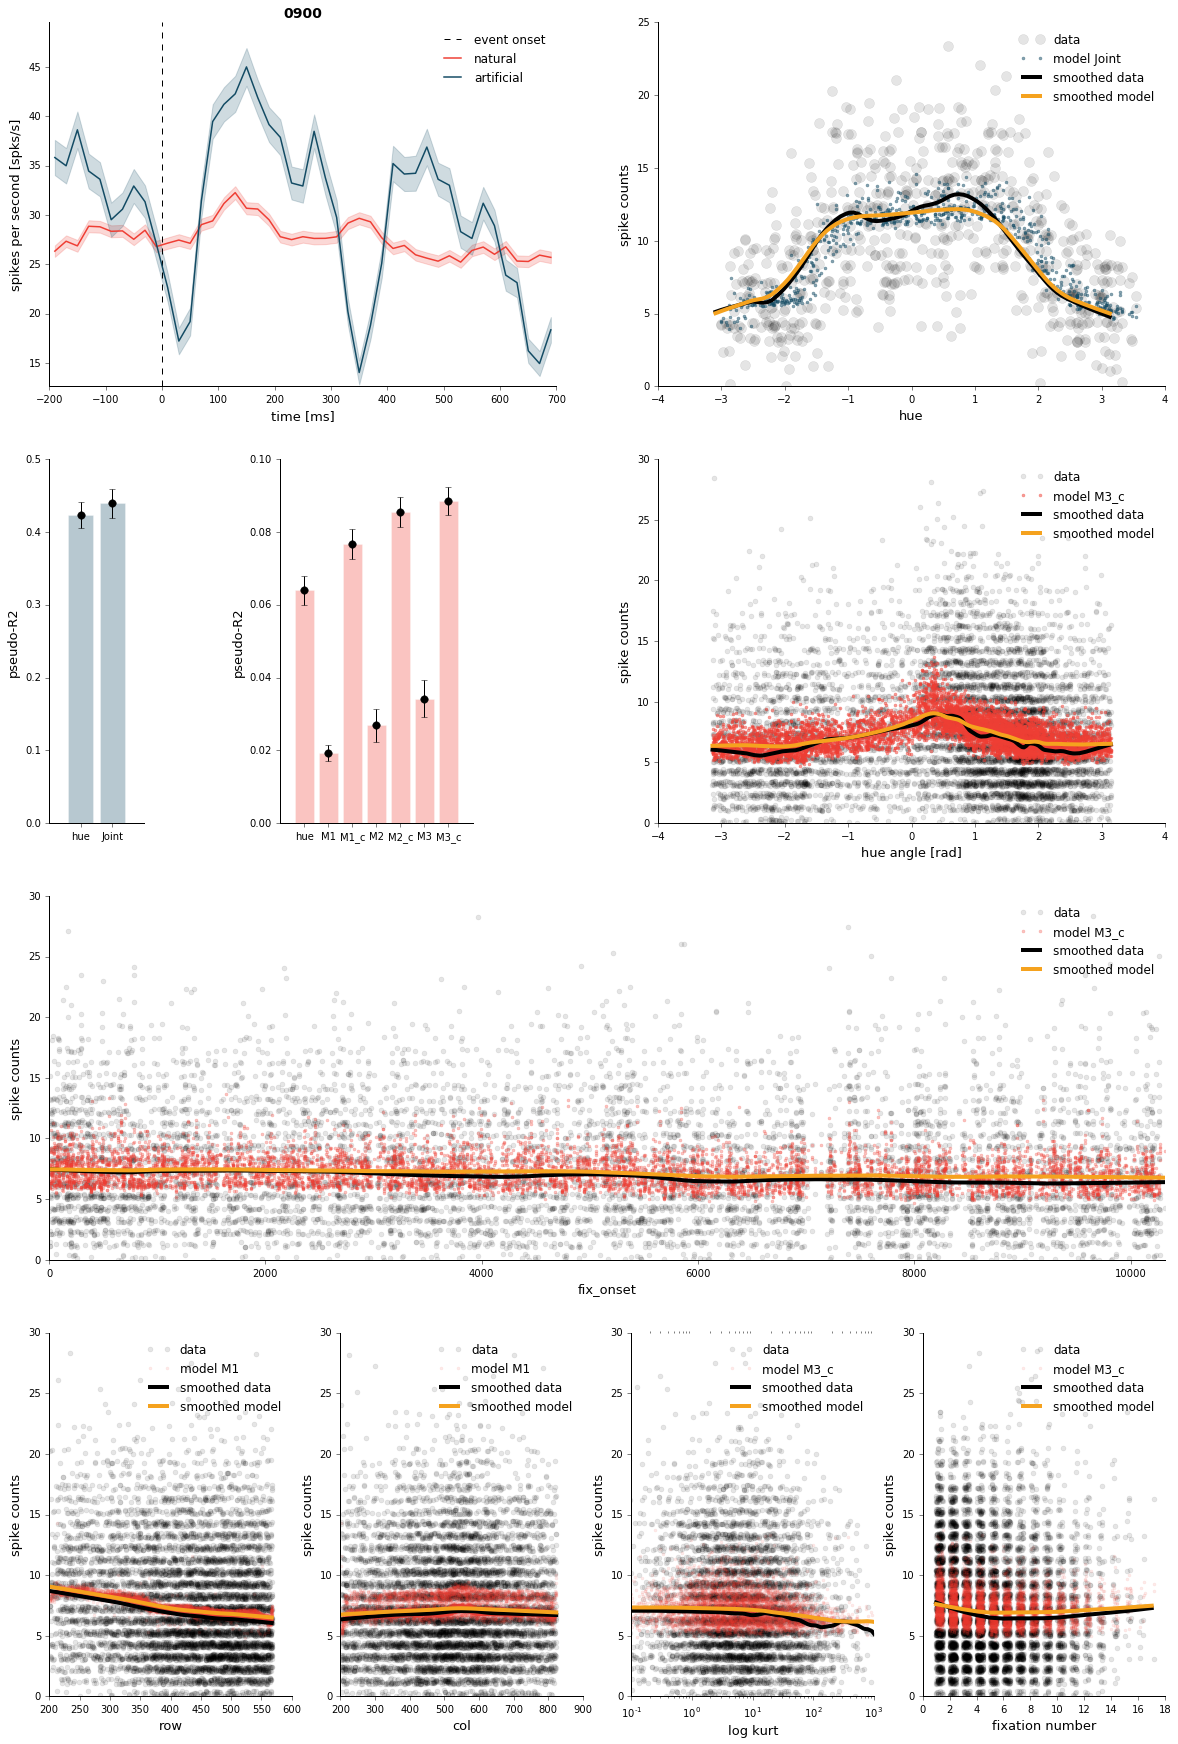

In [39]:
colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E', '#FF07CD']

title=art_neuron.name[:-4]
color_data_art = colors[1]
color_data_nat = colors[2]
color_model_art = colors[0]
color_model_nat = colors[0]

models_for_plot = ['hue','Joint']
patch_choose=14
model_nat = 'M3_c'

plt.figure(figsize=(20,30))
plt.title(title)

plt.subplot(421)
V4pyutils.plot_psth(psth, condition_names=['natural', 'artificial'], colors=[color_data_nat, color_data_art], 
                    event_name='event onset')
plt.title(title)


plt.subplot(422)
model='Joint'
x_variable = features_art_df['hue']
y_counts = Yart[selected_neuron]
xlabel='hue'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_art, 
                             model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5, 
                             model_alpha=0.5, colors=[color_model_art, color_data_art], data_ms=20)


plt.subplot(4,10,11)
V4pyutils.plot_model_comparison(models_for_plot, models=Models_art, color=[color_data_art])


plt.subplot(4,5,7)
models_for_plot = ['hue','M1', 'M1_c', 'M2', 'M2_c', 'M3', 'M3_c']
V4pyutils.plot_model_comparison(models_for_plot, models=Models_nat, color=[color_data_nat])


plt.subplot(4,2,4)
model='M3_c'
x_variable =np.arctan2(np.sin(hue_nat_mean[patch_choose]), np.cos(hue_nat_mean[patch_choose]))
y_counts = Ynat[selected_neuron]
xlabel='hue angle [rad]'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.1, xlabel=xlabel, xnoise=0, ynoise=0.5, model_alpha=0.5)

#----------------------------------------------------------------------------------------------
if 0:
    ylim = [-0.03,0.1]
    for patch_n in PR2_nat:
        mean_pR2 = np.mean(PR2_nat[patch_n])
        sem_pR2 = np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n]))
        mean_pR2_shuf = np.mean(PR2_nat_shuf[patch_n])
        sem_pR2_shuf = np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf[patch_n]))

        plt.subplot(16,8,36 + np.floor(patch_n / 4) * 8 + (patch_n % 4)+1)

        if patch_n > 11:
            plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
                    ecolor='k', alpha=0.4, color=[color_data_nat,color_data_nat], 
                    ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
                    tick_label=['nat','nat_shuf'])
        else:
            plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
                    ecolor='k', alpha=0.4, color=[color_data_nat,color_data_nat], 
                    ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
                    tick_label=['',''])

        plt.plot([-1,1],[0,0],'--k', alpha=0.4)
        plt.plot([0,1], [mean_pR2, mean_pR2_shuf], '.', c='k', markersize=13)
        plt.xlim([-1,2])

        plt.ylim(ylim)

        ax = plt.gca()
         
        if patch_n%4==0:
            plt.ylabel('pseudo-R2')
            plt.yticks([ylim[0],0,ylim[1]],[ylim[0],'0',ylim[1]])
        if patch_n%4>0:
            ax.spines['left'].set_visible(False)
            plt.yticks(ylim,['',''])
            plt.tick_params(axis='y', left='off')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.tick_params(axis='y', right='off')
        plt.tick_params(axis='x', top='off')
#----------------------------------------------------------------------------------------------



plt.subplot(413)
model='M3_c'
x_variable = features_nat_df['fix_onset'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='fix_onset'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.2, xlabel=xlabel, xnoise=0.5,
                   model_alpha=0.3)
plt.xlim([0,x_variable.values[-1]])



plt.subplot(4,4,13)
model='M1'
x_variable = features_nat_df['row'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='row'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5)


plt.subplot(4,4,14)
model='M1'
x_variable = features_nat_df['col'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='col'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5)



plt.subplot(4,4,15)
model='M3_c'
x_variable = hue_nat_kurt[patch_choose]
y_counts = Ynat[selected_neuron]
xlabel='log kurt'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5,
                   semilogx=True)
plt.xlim([10e-2, 10e2])

plt.subplot(4,4,16)
model='M3_c'
x_variable = features_nat_df['fixation'][fixation_list]
y_counts = Ynat[selected_neuron]
xlabel='fixation number'
V4pyutils.plot_var_vs_counts(x_variable=x_variable, y_counts=y_counts, models_fit=Models_nat, 
                   model=model, lowess_frac = 0.5, xlabel=xlabel, xnoise=0.5, ynoise=0.5)

plt.savefig('dash_board_%s.pdf' % nat_neuron.name[:-4])
plt.show()

### Vis: model vs data

/home/klab/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


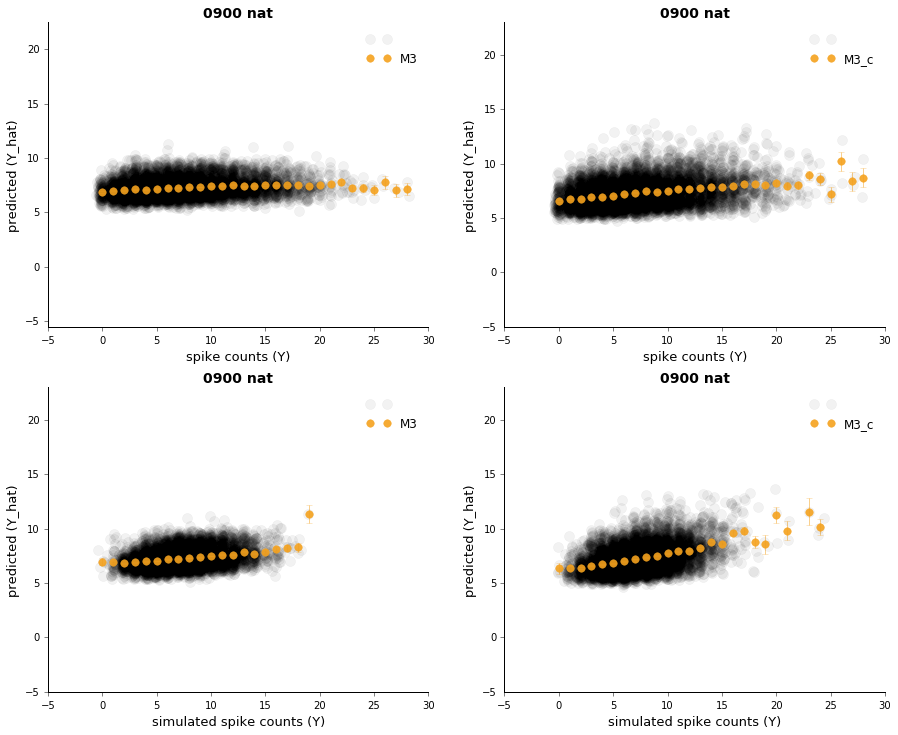

In [40]:
plt.figure(figsize=(15,12))
title = nat_neuron.name

ylim = []
plt.subplot(221)
models_for_plot = ['M3']
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Ynat[selected_neuron], models=Models_nat, 
                                   title=title, ylim=ylim)

plt.subplot(222)
models_for_plot = ['M3_c']
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Ynat[selected_neuron], models=Models_nat, title=title, 
                                   ylim=ylim)

plt.subplot(223)
models_for_plot = ['M3']#, 'M5_c']
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Ynat[selected_neuron], models=Models_nat, title=title, 
                                   ylim=ylim, simul=True)

plt.subplot(224)
models_for_plot = ['M3_c']
V4pyutils.plot_predicted_vs_counts(models_for_plot=models_for_plot,
                                   Y=Ynat[selected_neuron], models=Models_nat, title=title, 
                                   ylim=ylim, simul=True)

plt.show()

### Vis: model vs model

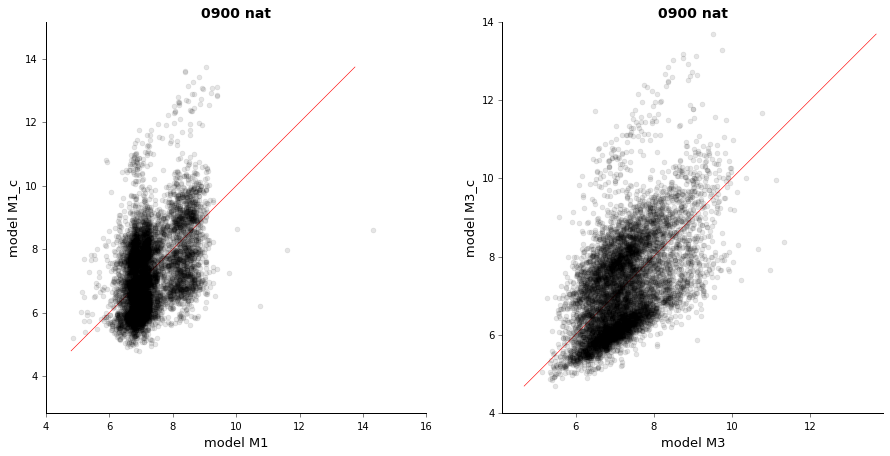

In [41]:
plt.figure(figsize=(15,7))
plt.subplot(121)
models_for_plot = ['M1','M1_c']
title = '%s nat' % params['selected_neuron']
V4pyutils.plot_model_vs_model(models_for_plot=models_for_plot, models=Models_nat, title=title)

plt.subplot(122)
models_for_plot = ['M3','M3_c']
title = '%s nat' % params['selected_neuron']
V4pyutils.plot_model_vs_model(models_for_plot=models_for_plot, models=Models_nat, title=title)

plt.show()

Could it be spike sorting?
Search for any change in behavior:
- try fixations per trial
- percent of valid fixations per trial

# Synthetic NeuroPhys

In [42]:
import numpy.matlib

hue_line = np.linspace(-np.pi, np.pi, 16)
Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
patch_n=14

X = features_nat_df[Models_nat['M1']['covariates']].values[fixation_list]
#sub_idx =features_nat_df['fix_offset'].values[fixation_list]<1000000

XXr = np.concatenate((X, Xnat[patch_n]), axis=1)
XXr_shuf = np.concatenate((X, Xnat_shuf[patch_n]), axis=1)

#XXt = np.matlib.repmat(np.median(X, axis=0), np.shape(Xart_line)[0], 1)

n_repeats = 100
Xart_line_rep = np.matlib.repmat(Xart_line, n_repeats, 1)
hue_line_rep = np.matlib.repmat(hue_line, 1, n_repeats)

idx = np.random.randint(0, np.shape(X)[0], size=np.shape(Xart_line_rep)[0])
XXt = X[idx,:]

#XXt = X[0:np.shape(Xart_line)[0], :]
XXt = np.concatenate((XXt, Xart_line_rep), axis=1)

Yline_nat_hat = V4pyutils.XGB_poisson(XXr, Ynat[selected_neuron], XXt)
Yline_nat_shuf_hat = V4pyutils.XGB_poisson(XXr_shuf, Ynat[selected_neuron], XXt)
Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

In [43]:
Yline_nat_hat
meanYt = list()
stdYt = list()
meanYtshuf = list()
stdYtshuf = list()
for i in np.unique(hue_line_rep):
    loc = np.where(hue_line_rep==i)[1]
    meanYt.append(np.mean(Yline_nat_hat[loc]))
    stdYt.append(np.std(Yline_nat_hat[loc]))
    meanYtshuf.append(np.mean(Yline_nat_shuf_hat[loc]))
    stdYtshuf.append(np.std(Yline_nat_shuf_hat[loc]))

meanYt = np.array(meanYt)
stdYt = np.array(stdYt)
meanYtshuf = np.array(meanYtshuf)
stdYtshuf = np.array(stdYtshuf)

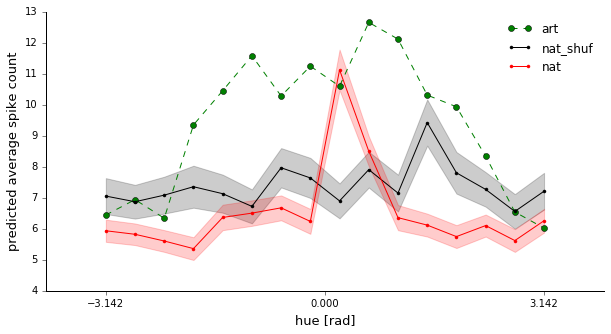

In [44]:
plt.figure(figsize=(10,5))
plt.plot(hue_line, Yline_art_hat,'o--g')
#plt.plot(hue_line, meanYt, 'o')
#plt.plot(np.squeeze(hue_line_rep), Yline_nat_hat,'o--r')
#plt.plot(np.squeeze(hue_line_rep), Yline_nat_shuf_hat,'o--k')

plt.plot(hue_line, meanYtshuf, '-k.')
plt.fill_between(hue_line, meanYtshuf-stdYtshuf, meanYtshuf+stdYtshuf, color='k', alpha=0.2)

plt.plot(hue_line, meanYt, '-r.')
plt.fill_between(hue_line, meanYt-stdYt, meanYt+stdYt, color='r', alpha=0.2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.ylabel('predicted average spike count')
plt.xlabel('hue [rad]')
plt.xticks(np.linspace(-np.pi,np.pi,3))
plt.legend(['art', 'nat_shuf', 'nat'],frameon= False, loc=0)
plt.show()

### Check for effect of hue histogram spread

### Check for effect of fixation order

In [46]:
def run_synthetic(X, Y, hue_line, verbose = 1):
    Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
    Yline_hat = dict()
    
    for patch_n in X:
        if verbose:
            print 'running %d of %d' % (patch_n+1, len(X))
        Yline_hat[patch_n] = V4pyutils.XGB_poisson(X[patch_n], Y, Xart_line)
    
    return Yline_hat

In [47]:
Yline_nat_hat  = run_synthetic(Xnat, Ynat[selected_neuron], hue_line, verbose=0)
Yline_nat_shuf_hat  = run_synthetic(Xnat_shuf, Ynat[selected_neuron], hue_line, verbose=0)

Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

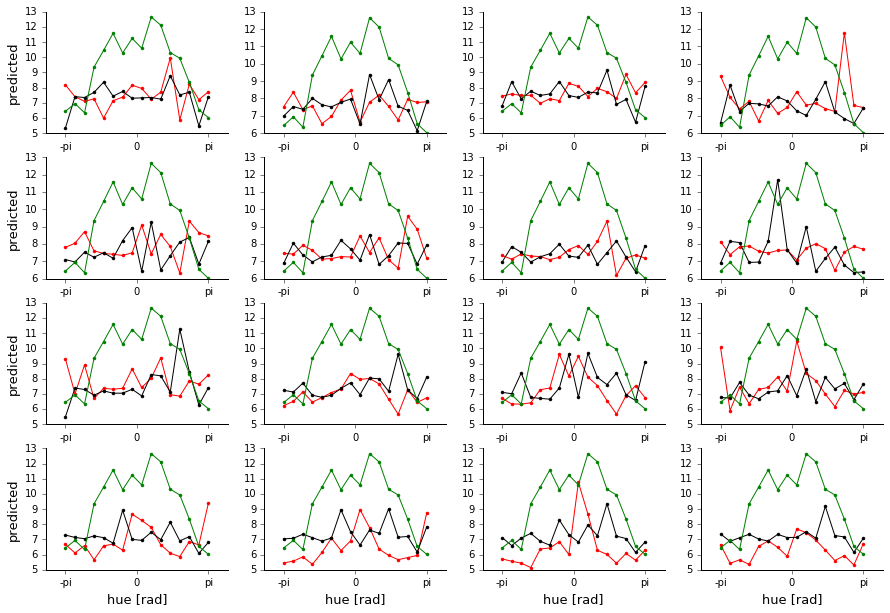

In [48]:
plt.figure(figsize=(15,10))
for patch_n in Yline_nat_hat:
    plt.subplot(4,4,patch_n+1)
    plt.plot(hue_line, Yline_nat_hat[patch_n],'.-r')
    plt.plot(hue_line, Yline_nat_shuf_hat[patch_n],'.-k')
    plt.plot(hue_line, Yline_art_hat,'.-g')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    if patch_n%4==0:
        plt.ylabel('predicted')
    if patch_n>11:
        plt.xlabel('hue [rad]')
    plt.xticks(np.linspace(-np.pi,np.pi,3), ['-pi','0','pi'])
    #plt.legend(['art', 'nat', 'nat_shuf'],frameon= False)
    #plt.ylim([3,13])
plt.savefig('sample.pdf')
plt.show()



In [ ]:
#What's next?
#CNNs, 1st transfer learning, 2nd, train